In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns; sns.set(style="white", font_scale=2)

import numpy as np
import pandas as pd
from astropy.io import fits
import glob

import sklearn

import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers.noise import GaussianNoise

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import random_channel_shift
from keras.optimizers import SGD, Adam
from keras import backend as K
K.set_image_data_format('channels_first')

import scipy.ndimage as ndi

import matplotlib.patches as patches


Using TensorFlow backend.


In [162]:
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = np.array((10,6))*.6
mpl.rcParams['figure.facecolor'] = "white"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# give access to importing dwarfz
import os, sys
dwarfz_package_dir = os.getcwd().split("dwarfz")[0]
if dwarfz_package_dir not in sys.path:
    sys.path.insert(0, dwarfz_package_dir)

import dwarfz
    
# back to regular import statements

In [4]:
# my modules that are DNN specific
import preprocessing
import geometry

# To Do
 1. Read in fits images
 2. Apply pre-processing stretch (asinh)
 3. crop image smaller
 4. Combine filters into one cube
 5. Create training set with labels
 6. Set up keras model
 7. Poke around at the results
 
 

# 0) Get files

In [5]:
images_dir = preprocessing.images_dir
images_dir

'../data/galaxy_images_training/quarry_files/'

In [6]:
HSC_ids = [int(os.path.basename(image_file).split("-")[0])
           for image_file in glob.glob(os.path.join(images_dir, "*.fits"))]
HSC_ids = set(HSC_ids) # remove duplicates
HSC_ids = np.array(sorted(HSC_ids))

# now filter out galaxies missing bands
HSC_ids = [HSC_id
           for HSC_id in HSC_ids
           if len(glob.glob(os.path.join(images_dir, "{}*.fits".format(str(HSC_id)))))==5]
HSC_ids = np.array(HSC_ids)

In [7]:
HSC_ids.size

1866

In [8]:
HSC_id = HSC_ids[1] # for when I need a single sample galaxy

In [9]:
bands = ["g", "r", "i", "z", "y"]

# 1) Read in fits image


In [10]:
image, flux_mag_0 = preprocessing.get_image(HSC_id, "g")
print("image size: {} x {}".format(*image.shape))
image

image size: 239 x 239


array([[-0.00146446,  0.02150147,  0.00693631, ...,  0.02792656,
        -0.02018547,  0.01850448],
       [-0.02519608,  0.00035813, -0.0455959 , ..., -0.00586783,
        -0.00882499,  0.01241659],
       [ 0.03936524,  0.00645859, -0.02110163, ...,  0.02997875,
         0.009456  ,  0.00591614],
       ...,
       [-0.03543996,  0.04346127, -0.0372493 , ..., -0.0014411 ,
        -0.01001758,  0.03473332],
       [-0.01037648, -0.03287457,  0.04310744, ...,  0.02935715,
         0.02273993, -0.00532476],
       [-0.05991019, -0.08159582,  0.02607481, ...,  0.01012528,
         0.00453719, -0.00872836]], dtype=float32)

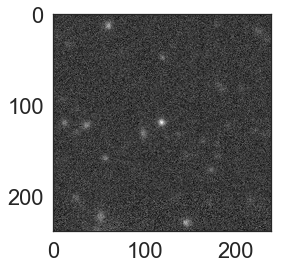

In [11]:
preprocessing.image_plotter(image)

/Users/egentry/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


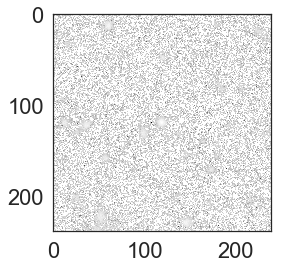

In [12]:
preprocessing.image_plotter(np.log(image))

# 2) Apply stretch

We're using (negative) asinh magnitudes, as implemented by the HSC collaboration.

To see more about asinh magnitude system, see : [Lupton, Gunn and Szalay (1999)](http://iopscience.iop.org/article/10.1086/301004/meta) used for SDSS. (It's expliticly given in the [SDSS Algorithms](http://classic.sdss.org/dr7/algorithms/fluxcal.html) documentation as well as [this overview page](https://ned.ipac.caltech.edu/help/sdss/dr6/photometry.html#asinh)).

To see the source of our code, see: [the HSC color image creator](https://hsc-gitlab.mtk.nao.ac.jp/snippets/23#L172)

And for reference, a common form of this stretch is:
$$ \mathrm{mag}_\mathrm{asinh} = - \left(\frac{2.5}{\ln(10)}\right) \left(\mathrm{asinh}\left(\frac{f/f_0}{2b}\right) + \ln(b) \right)$$
for dimensionless softening parameter $b$, and reference flux (f_0).


In [13]:
def scale(x, fluxMag0):
    ### adapted from https://hsc-gitlab.mtk.nao.ac.jp/snippets/23
    mag0 = 19
    scale = 10 ** (0.4 * mag0) / fluxMag0
    x *= scale

    u_min = -0.05
    u_max = 2. / 3.
    u_a = np.exp(10.)

    x = np.arcsinh(u_a*x) / np.arcsinh(u_a)
    x = (x - u_min) / (u_max - u_min)

    return x


In [14]:
image_scaled = preprocessing.scale(image, flux_mag_0)

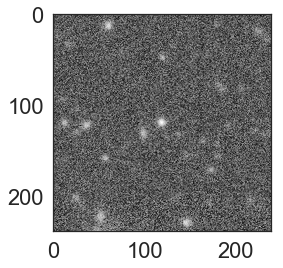

In [15]:
preprocessing.image_plotter(image_scaled)

/Users/egentry/anaconda3/envs/tf/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of Transformed Intensities')

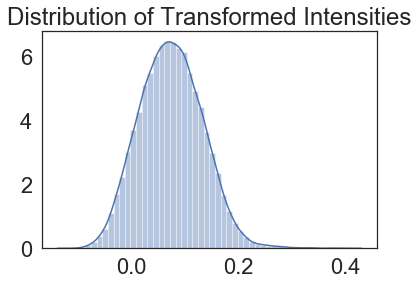

In [16]:
sns.distplot(image_scaled.flatten())
plt.title("Distribution of Transformed Intensities")

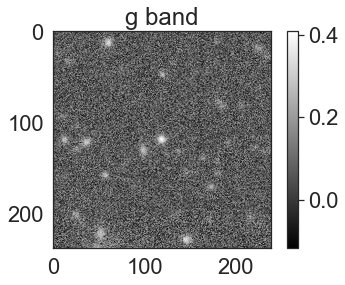

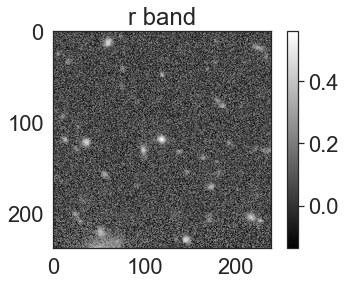

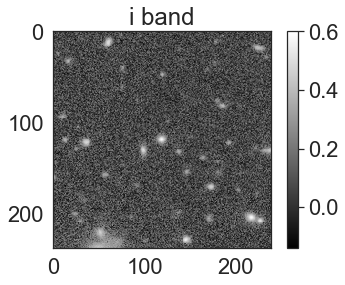

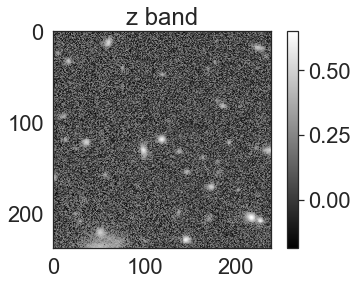

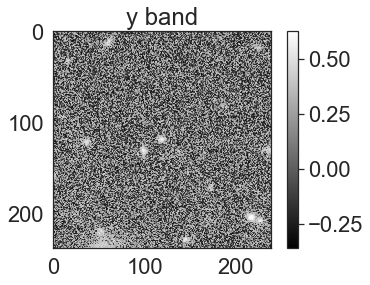

In [17]:
for band in bands:
    image, flux_mag_0 = preprocessing.get_image(HSC_id, band)
    image_scaled = preprocessing.scale(image, flux_mag_0)

    plt.figure()
    preprocessing.image_plotter(image_scaled)
    plt.title("{} band".format(band))
    plt.colorbar()

# 3) Crop Image
Am I properly handling odd numbers?

In [18]:
pre_transformed_image_size  = 150
post_transformed_image_size = 75

In [19]:
cutout = preprocessing.get_cutout(image_scaled, post_transformed_image_size)
cutout.shape

(75, 75)

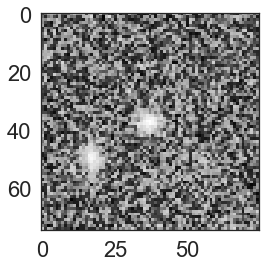

In [20]:
preprocessing.image_plotter(cutout)

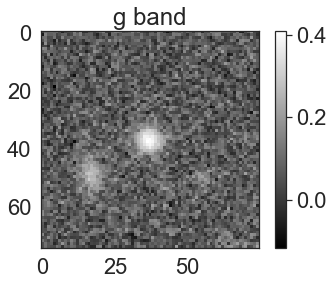

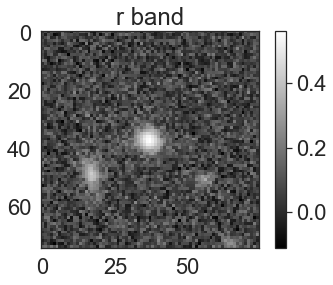

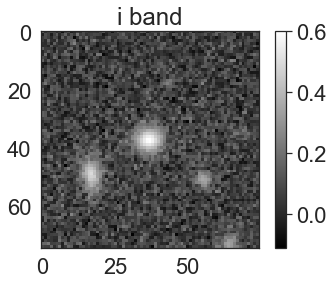

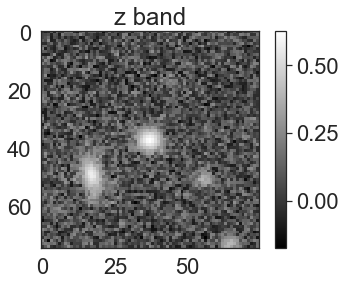

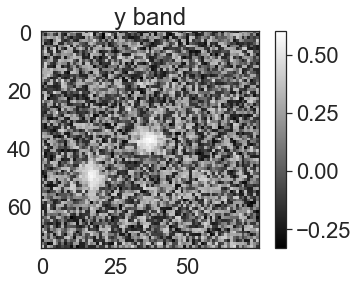

In [21]:
for band in bands:
    image, flux_mag_0 = preprocessing.get_image(HSC_id, band)
    image_scaled = preprocessing.scale(image, flux_mag_0)
    cutout = preprocessing.get_cutout(image_scaled, post_transformed_image_size)

    plt.figure()
    preprocessing.image_plotter(cutout)
    plt.title("{} band".format(band))
    plt.colorbar()

# 4) Combine filters into cube

In [22]:
images = [None]*len(bands)
flux_mag_0s = [None]*len(bands)
cutouts = [None]*len(bands)
for i, band in enumerate(bands):
    images[i], flux_mag_0s[i] = preprocessing.get_image(HSC_id, band)
    
    cutouts[i] = preprocessing.get_cutout(
        preprocessing.scale(images[i], flux_mag_0s[i]), 
        post_transformed_image_size
    )


In [23]:
cutout_cube = np.array(cutouts)
cutout_cube.shape

(5, 75, 75)

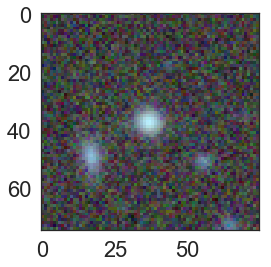

In [24]:
# must transform into [0,1] for plt.imshow
# the HSC standard tool accomplishes this by clipping instead.
plt.imshow(preprocessing.transform_0_1(cutout_cube[:3,:,:].transpose(1,2,0)) )

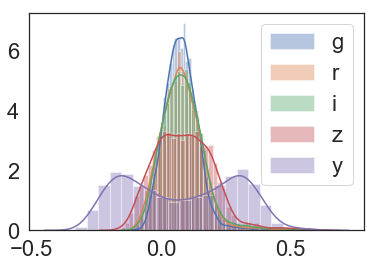

In [25]:
for i, band in enumerate(bands):
    sns.distplot(cutout_cube[:,:,:].transpose(1,2,0)[:,:,i].flatten(), label=band)
    plt.legend(loc="best")

# 5) Load Training Set Labels

In [26]:
training_set_labels_filename = "../data/galaxy_images_training/2017_09_26-dwarf_galaxy_scores.csv"

In [27]:
df = pd.read_csv(training_set_labels_filename)
df = df.drop_duplicates("HSC_id")
df = df.set_index("HSC_id")
df = df[["low_z_low_mass"]]
df = df.rename(columns={"low_z_low_mass":"target"})
df.head()

,target
HSC_id,
43158322471244656,False
43158605939114836,False
43159142810013665,False
43158734788125011,False
43158863637144621,True


In [29]:
def load_image_mappable(HSC_id):
    images      = [None]*len(bands)
    flux_mag_0s = [None]*len(bands)
    cutouts     = [None]*len(bands)
    for j, band in enumerate(bands):
        images[j], flux_mag_0s[j] = preprocessing.get_image(HSC_id, band)
        cutouts[j] = preprocessing.get_cutout(
            preprocessing.scale(images[j], flux_mag_0s[j]),
            pre_transformed_image_size)
    cutout_cube = np.array(cutouts)
    return cutout_cube

In [30]:
X = np.empty((len(HSC_ids), 5, 
              pre_transformed_image_size, pre_transformed_image_size))

In [31]:
X = np.array(list(map(load_image_mappable, HSC_ids)))

In [33]:
X_full = X
X_small = X[:,(0,2,4),:,:] # drop down to 3 bands

In [34]:
X.shape

(1866, 5, 150, 150)

In [35]:
Y = df.loc[HSC_ids].target.values
Y

array([False, False,  True, ..., False, False, False])

In [36]:
Y.mean()

0.2792068595927117

# Geometry!

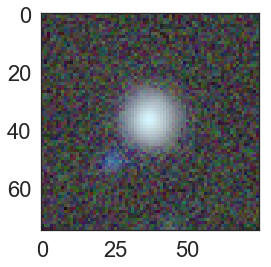

In [37]:
h = pre_transformed_image_size
w = pre_transformed_image_size
transform_matrix = geometry.create_random_transform_matrix(h, w,
                                                  include_rotation=True,
                                                  translation_size = .01,
                                                  verbose=False)

x_tmp = X[0][:3]

result = geometry.apply_transform_new(x_tmp, transform_matrix, 
                            channel_axis=0, fill_mode="constant", cval=np.max(x_tmp))

result = preprocessing.get_cutout(x_tmp, post_transformed_image_size)
plt.imshow(preprocessing.transform_0_1(result.transpose(1,2,0)))

In [38]:
import ipywidgets
ipywidgets.interact(preprocessing.transform_plotter,
                    X = ipywidgets.fixed(X),
                    rotation_degrees = ipywidgets.IntSlider(min=0, max=360, step=15, value=45),
                    dx_after = ipywidgets.IntSlider(min=-15, max=15),
                    dy_after = ipywidgets.IntSlider(min=-15, max=15),
                    color = ipywidgets.fixed(True),
                    shear_degrees = ipywidgets.IntSlider(min=0, max=90, step=5, value=0),
                    zoom_x = ipywidgets.FloatSlider(min=.5, max=2, value=1),
                    crop = ipywidgets.Checkbox(value=True)
                    )

interactive(children=(Checkbox(value=False, description='reflect_x'), IntSlider(value=45, description='rotatio…

<function preprocessing.transform_plotter(X, reflect_x=False, rotation_degrees=45, dx_after=0, dy_after=0, shear_degrees=0, zoom_x=1, crop=False, color=True)>

## 5b) Split training and testing set

In [119]:
np.random.seed(1)

randomized_indices = np.arange(X.shape[0])
np.random.shuffle(randomized_indices)

testing_fraction = 0.2
testing_set_indices = randomized_indices[:int(testing_fraction*X.shape[0])]
training_set_indices = np.array(list(set([*randomized_indices]) - set([*testing_set_indices])))

In [120]:
testing_set_indices.size

373

In [121]:
training_set_indices.size

1493

## 6b) Adapt NumpyArrayIterator
The original only allowed 1, 3 or 4 channel images. I have 5 channel images.

Also, I want to change the way that augmentation is happening

In [122]:
from data_generator import ArrayIterator

## 6c) Adapt ImageDataGenerator
The original only allowed 1, 3 or 4 channel images. I have 5 channel images. Also, I'm adjusting the way that the affine transformations work for the data augmentation

In [123]:
from data_generator import ImageDataGenerator

## 6d) Create Data Generator

In [124]:
print('Using real-time data augmentation.')

h_before, w_before = X[0,0].shape
print("image shape before: ({},{})".format(h_before, w_before))

h_after = post_transformed_image_size
w_after = post_transformed_image_size
print("image shape after:  ({},{})".format(h_after, w_after))

# get a closure that binds the image size to get_cutout
postprocessing_function = lambda image: preprocessing.get_cutout(image, post_transformed_image_size)

# this will do preprocessing and realtime data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    with_reflection_x=True, # randomly apply a reflection (in x)
    with_reflection_y=True, # randomly apply a reflection (in y)
    with_rotation=False, # randomly apply a rotation
    width_shift_range=0.002,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.002,  # randomly shift images vertically (fraction of total height)
    postprocessing_function=postprocessing_function, # get a cutout of the processed image
    output_image_shape=(post_transformed_image_size,post_transformed_image_size)
)   

Using real-time data augmentation.
image shape before: (150,150)
image shape after:  (75,75)


In [125]:
datagen.fit(X_full[training_set_indices])

# 7) Set up `keras` model

In [142]:
input_shape = cutout_cube.shape

nb_dense = 64

In [143]:
from keras.applications import inception_v3, inception_resnet_v2, vgg19

In [144]:
vgg19.VGG19(include_top=False, input_shape=(3, 75, 75))

In [146]:
model = Sequential()

# # # 1x1 convolution to make sure we only have 3 channels
n_channels_for_pretrained=3
one_by_one = Conv2D(n_channels_for_pretrained, 1, padding='same',
                 input_shape=input_shape)
model.add(one_by_one)

pretrained_input_shape = tuple([n_channels_for_pretrained, *input_shape[1:]])
pretrained_layers = vgg19.VGG19(include_top=False,
                                input_shape=pretrained_input_shape
                               )
for layer in pretrained_layers.layers:
    layer.trainable = False
model.add(pretrained_layers)

model.add(Flatten())
model.add(Dense(2*nb_dense, activation="relu"))
model.add(Dense(nb_dense, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [147]:
model.layers

In [148]:
learning_rate = 0.00025
decay = 1e-5
momentum = 0.9

# sgd = SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)

adam = Adam(lr=learning_rate)

In [149]:
logger_filename = "training_transfer.one_by_one.log"

model.compile(loss='binary_crossentropy', 
#               optimizer=sgd, 
              optimizer=adam,
             )

# can only manually set weights _after_ compiling
one_by_one_weights = np.zeros((1,1,5,3))
for i in range(3):
    one_by_one_weights[0, 0, i, i] = 1.
one_by_one.set_weights([one_by_one_weights,
                        np.zeros(3)])

if os.path.exists(logger_filename):
    logger_filename_tmp = logger_filename + ".old"
    os.rename(logger_filename, logger_filename_tmp)


In [150]:
earlystopping = EarlyStopping(monitor='loss',
                              patience=35,
                              verbose=1,
                              mode='auto' )


In [151]:
csv_logger = keras.callbacks.CSVLogger(logger_filename,
                                       append=True)

In [152]:
# modelcheckpoint = ModelCheckpoint(pathinCat+'Models/bestmodelMAG.hdf5',monitor='val_loss',verbose=0,save_best_only=True)


# 8) Run basic keras model

In [153]:
goal_batch_size = 64
steps_per_epoch = max(2, training_set_indices.size//goal_batch_size)
batch_size = training_set_indices.size//steps_per_epoch
print("steps_per_epoch: ", steps_per_epoch)
print("batch_size: ", batch_size)
epochs = 200
verbose = 1

steps_per_epoch:  23
batch_size:  64


In [154]:
X_test_transformed = np.array([datagen.standardize(X_img)
                               for X_img in X_full[testing_set_indices]])

X_test_transformed.shape

(373, 5, 75, 75)

In [156]:
history = model.fit_generator(datagen.flow(X_full[training_set_indices], 
                                           Y[training_set_indices],
                                           batch_size=batch_size,
                                          ),
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=(X_test_transformed, 
                                               Y[testing_set_indices]),
                              verbose=verbose,
                              callbacks=[
#                                   earlystopping,
                                  csv_logger],
                              )  


Epoch 1/200
23/23 [==============================] - 183s 8s/step - loss: 0.6205 - val_loss: 0.6131
Epoch 2/200
23/23 [==============================] - 186s 8s/step - loss: 0.5914 - val_loss: 0.6128
Epoch 3/200
23/23 [==============================] - 181s 8s/step - loss: 0.5782 - val_loss: 0.6128
Epoch 4/200
23/23 [==============================] - 178s 8s/step - loss: 0.6093 - val_loss: 0.6154
Epoch 5/200
23/23 [==============================] - 181s 8s/step - loss: 0.5846 - val_loss: 0.6055
Epoch 6/200
23/23 [==============================] - 181s 8s/step - loss: 0.5933 - val_loss: 0.6058
Epoch 7/200
23/23 [==============================] - 180s 8s/step - loss: 0.5892 - val_loss: 0.6069
Epoch 8/200
23/23 [==============================] - 181s 8s/step - loss: 0.5946 - val_loss: 0.6041
Epoch 9/200
23/23 [==============================] - 185s 8s/step - loss: 0.5816 - val_loss: 0.6011
Epoch 10/200
23/23 [==============================] - 181s 8s/step - loss: 0.5840 - val_loss: 0.6013

23/23 [==============================] - 315s 14s/step - loss: 0.5508 - val_loss: 0.6584
Epoch 163/200
23/23 [==============================] - 317s 14s/step - loss: 0.5823 - val_loss: 0.5986
Epoch 164/200
23/23 [==============================] - 309s 13s/step - loss: 0.5696 - val_loss: 0.5942
Epoch 165/200
23/23 [==============================] - 324s 14s/step - loss: 0.5671 - val_loss: 0.5930
Epoch 166/200
23/23 [==============================] - 316s 14s/step - loss: 0.5732 - val_loss: 0.6046
Epoch 167/200
23/23 [==============================] - 317s 14s/step - loss: 0.5848 - val_loss: 0.6038
Epoch 168/200
23/23 [==============================] - 316s 14s/step - loss: 0.5610 - val_loss: 0.5962
Epoch 169/200
23/23 [==============================] - 316s 14s/step - loss: 0.5677 - val_loss: 0.5963
Epoch 170/200
23/23 [==============================] - 315s 14s/step - loss: 0.5691 - val_loss: 0.6037
Epoch 171/200
23/23 [==============================] - 317s 14s/step - loss: 0.5664 - v

In [157]:
logged_history = pd.read_csv(logger_filename)
logged_history

,epoch,loss,val_loss
0,0,0.625163,0.613147
1,1,0.591443,0.612764
2,2,0.577214,0.612777
3,3,0.603634,0.615373
4,4,0.583025,0.605459
5,5,0.587915,0.605771
6,6,0.588803,0.606950
7,7,0.592144,0.604085
8,8,0.581558,0.601125
9,9,0.586347,0.601322


In [158]:
from sklearn.metrics import log_loss


In [159]:
p = Y[training_set_indices].mean()
prior_loss = log_loss(Y[testing_set_indices], 
                      [p]*testing_set_indices.size)

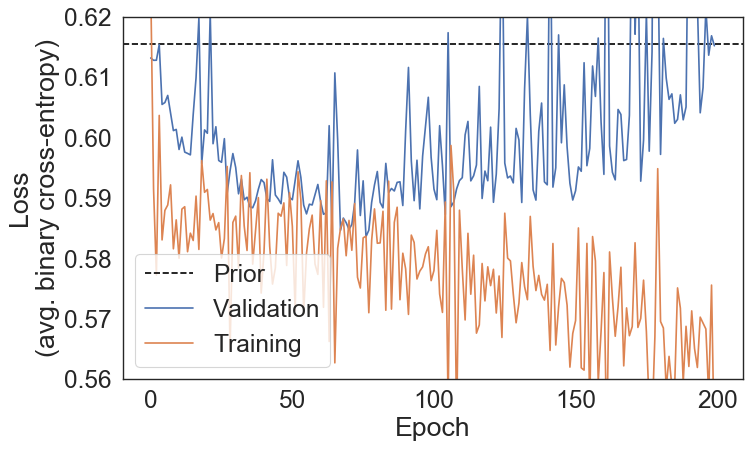

In [163]:
with mpl.rc_context(rc={"figure.figsize": (10,6)}):

        
    plt.axhline(prior_loss, label="Prior", 
                linestyle="dashed", color="black")
    
    plt.plot(logged_history["val_loss"], label="Validation")
    plt.plot(logged_history["loss"], label="Training")
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss\n(avg. binary cross-entropy)")
    
    plt.legend()
    
    plt.ylim(bottom=.56, top=.62)



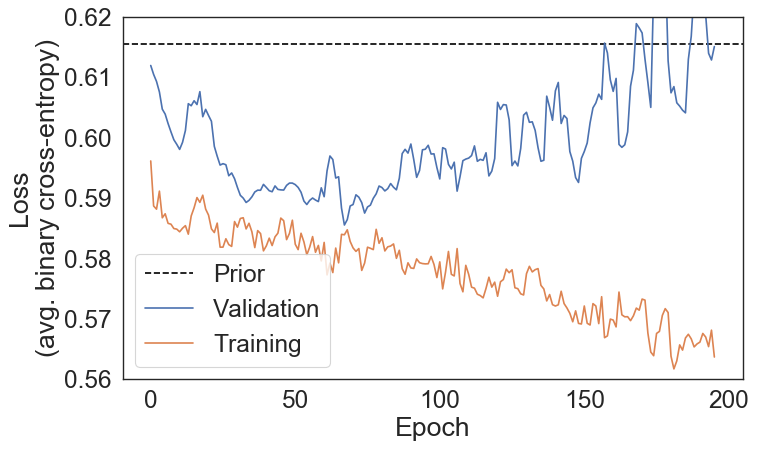

In [164]:
from sklearn.metrics import log_loss
with mpl.rc_context(rc={"figure.figsize": (10,6)}):

    simple_conv = lambda x: np.convolve(x, np.ones(5)/5, mode="valid")
    
    plt.axhline(prior_loss, label="Prior", 
                linestyle="dashed", color="black")
    
    plt.plot(simple_conv(logged_history["val_loss"]),
             label="Validation")
    plt.plot(simple_conv(logged_history["loss"]),
             label="Training")
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss\n(avg. binary cross-entropy)")
    
    plt.legend()
    
    plt.ylim(bottom=.56, top=.62)



# 9) Look at validation results

In [59]:
class_probs = model.predict_proba(X_test_transformed).flatten()
class_probs

373/373 [==============================] - 1s 3ms/step


array([0.38096353, 0.44315898, 0.42595476, 0.39431217, 0.44192123,
       0.42403397, 0.3084317 , 0.3977308 , 0.42297694, 0.44161874,
       0.4457367 , 0.4409836 , 0.40325916, 0.37228101, 0.28045028,
       0.39575815, 0.44849315, 0.4440918 , 0.4450764 , 0.4423715 ,
       0.4449345 , 0.41168362, 0.4467733 , 0.43635613, 0.44292593,
       0.41494936, 0.39176732, 0.39990672, 0.2934756 , 0.32629684,
       0.3822251 , 0.31482962, 0.3116483 , 0.4064709 , 0.30879626,
       0.2557003 , 0.41120014, 0.37519196, 0.44936234, 0.40176862,
       0.4401391 , 0.4009208 , 0.33045557, 0.43595022, 0.3117058 ,
       0.36470458, 0.42641282, 0.38719258, 0.22711629, 0.39770648,
       0.2820537 , 0.34835997, 0.43251485, 0.30706087, 0.25999638,
       0.40024894, 0.38270858, 0.3465161 , 0.38174748, 0.43951225,
       0.36454654, 0.37350082, 0.3985789 , 0.42196226, 0.43141177,
       0.391576  , 0.402127  , 0.445567  , 0.43924326, 0.4386993 ,
       0.4277306 , 0.43835342, 0.2692941 , 0.44942412, 0.45081

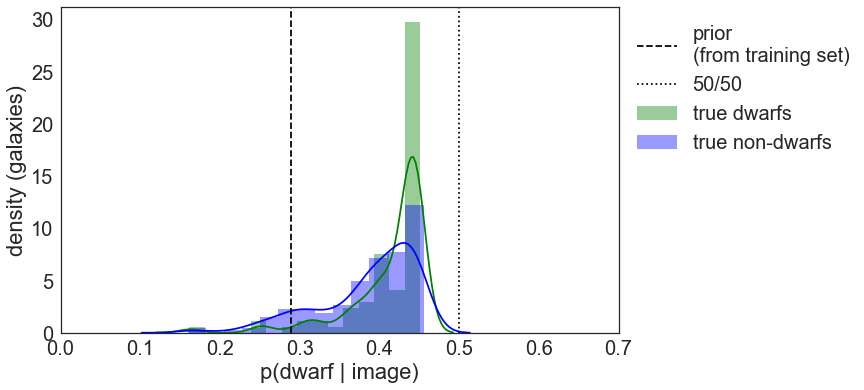

In [60]:
with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    sns.distplot(class_probs[Y[testing_set_indices]==True], color="g", label="true dwarfs")
    sns.distplot(class_probs[Y[testing_set_indices]==False], color="b", label="true non-dwarfs")

    plt.xlabel("p(dwarf | image)")
    plt.ylabel("density (galaxies)")

    plt.xlim(0, .7)
    plt.axvline(Y[training_set_indices].mean(), linestyle="dashed", color="black", label="prior\n(from training set)")
    plt.axvline(.5, linestyle="dotted", color="black", label="50/50")

    plt.legend(
        loc="upper left",
        bbox_to_anchor=(1, 1),
    )


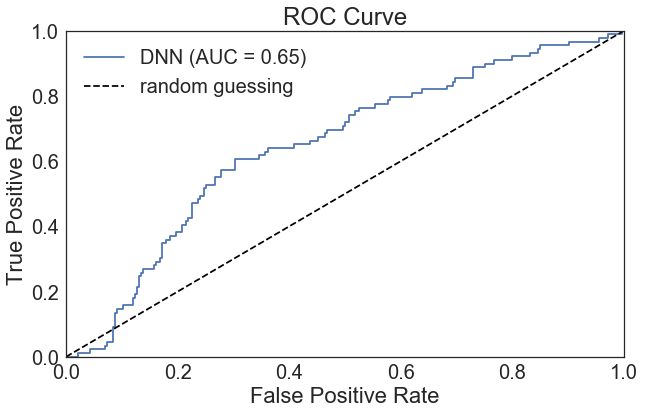

In [61]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    fpr, tpr, _ = metrics.roc_curve(Y[testing_set_indices], class_probs)
    roc_auc = roc_auc_score(Y[testing_set_indices], class_probs)

    plt.plot(fpr, tpr, label="DNN (AUC = {:.2})".format(roc_auc))
    plt.plot([0,1], [0,1], linestyle="dashed", color="black", label="random guessing")

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.title("ROC Curve")

    plt.legend(loc="best")


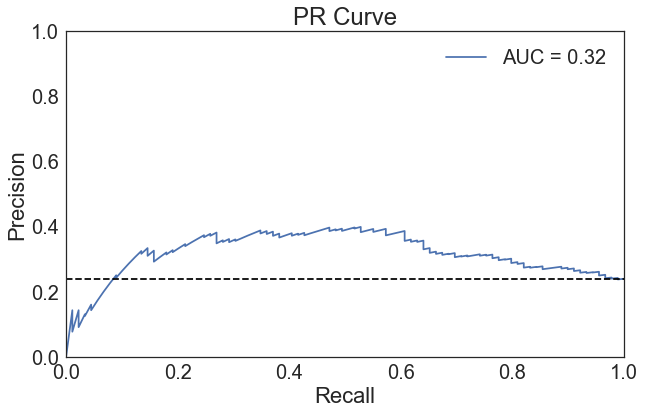

In [62]:
from sklearn.metrics import average_precision_score
with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    precision, recall, _ = metrics.precision_recall_curve(Y[testing_set_indices], class_probs)
    pr_auc = average_precision_score(Y[testing_set_indices], class_probs)

    plt.plot(recall, precision, label="AUC = {:.2}".format(pr_auc))
    plt.plot([0,1], [Y[testing_set_indices].mean()]*2, linestyle="dashed", color="black")

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("Recall")
    plt.ylabel("Precision")

    plt.title("PR Curve")

    plt.legend(loc="best")


## Apply a threshold
For now, just use a threshold using the prior class probability (estimated from the training set)

**Note** under a symmetric loss function, this isn't as good as 

In [63]:
predicted_classes = class_probs > (Y[training_set_indices].mean())
predicted_classes.mean()

0.9195710455764075

In [64]:
confusion_matrix = metrics.confusion_matrix(Y[testing_set_indices], predicted_classes)
confusion_matrix

array([[ 27, 257],
       [  3,  86]])

In [65]:
print("number of dwarfs (true)     : ", Y[testing_set_indices].sum())
print("number of dwarfs (predicted): ", predicted_classes.sum())

number of dwarfs (true)     :  89
number of dwarfs (predicted):  343


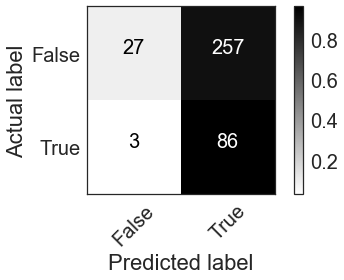

In [66]:
import itertools
# adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.imshow(confusion_matrix_normalized, interpolation='nearest',cmap="gray_r")
# plt.title(title)
plt.colorbar()
tick_marks = np.arange(2)
classes = [False, True]
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = 1 / 2.
for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    plt.text(j, i, format(confusion_matrix[i, j], fmt),
             fontdict={"size":20},
             horizontalalignment="center",
             color="white" if confusion_matrix_normalized[i, j] > thresh else "black")

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [69]:
print("  i - Y_true[i] - Y_pred[i] -  error?")
print("-------------------------------------")
for i in range(predicted_classes.size):
    print("{:>3} -    {:>1d}      -    {:d}      -   {:>2d}".format(i, 
                                                    Y[testing_set_indices][i], 
                                                    predicted_classes[i],
                                                    (Y[testing_set_indices][i] != predicted_classes[i]), 
                                                   ))

  i - Y_true[i] - Y_pred[i] -  error?
-------------------------------------
  0 -    0      -    1      -    1
  1 -    1      -    1      -    0
  2 -    0      -    1      -    1
  3 -    1      -    1      -    0
  4 -    0      -    1      -    1
  5 -    0      -    1      -    1
  6 -    0      -    1      -    1
  7 -    0      -    1      -    1
  8 -    0      -    1      -    1
  9 -    0      -    1      -    1
 10 -    1      -    1      -    0
 11 -    0      -    1      -    1
 12 -    1      -    1      -    0
 13 -    0      -    1      -    1
 14 -    0      -    0      -    0
 15 -    0      -    1      -    1
 16 -    0      -    1      -    1
 17 -    0      -    1      -    1
 18 -    1      -    1      -    0
 19 -    1      -    1      -    0
 20 -    0      -    1      -    1
 21 -    0      -    1      -    1
 22 -    1      -    1      -    0
 23 -    0      -    1      -    1
 24 -    0      -    1      -    1
 25 -    0      -    1      -    1
 26 -    0    

# Analyze Errors

In [77]:
HSC_ids

array([43158176442374224, 43158176442374373, 43158176442374445, ...,
       43159155694916013, 43159155694916476, 43159155694917496])

In [79]:
df.loc[HSC_ids[testing_set_indices]].head()

,target
HSC_id,
43158880817015286,False
43159142810013371,True
43158876522047030,False
43158863637144621,True
43158335356145699,False


In [80]:
COSMOS_filename = os.path.join(dwarfz.data_dir_default, 
                               "COSMOS_reference.sqlite")
COSMOS = dwarfz.datasets.COSMOS(COSMOS_filename)

In [81]:
HSC_filename = os.path.join(dwarfz.data_dir_default, 
                            "HSC_COSMOS_median_forced.sqlite3")
HSC = dwarfz.datasets.HSC(HSC_filename)

In [82]:
matches_filename = os.path.join(dwarfz.data_dir_default, 
                                "matches.sqlite3")
matches_df = dwarfz.matching.Matches.load_from_filename(matches_filename)

In [89]:
combined = matches_df[matches_df.match].copy()
combined["ra"]       = COSMOS.df.loc[combined.index].ra
combined["dec"]      = COSMOS.df.loc[combined.index].dec
combined["photo_z"]  = COSMOS.df.loc[combined.index].photo_z
combined["log_mass"] = COSMOS.df.loc[combined.index].mass_med
combined["active"]   = COSMOS.df.loc[combined.index].classification

combined = combined.set_index("catalog_2_ids")

combined.head()

,sep,match,error,ra,dec,photo_z,log_mass,active
catalog_2_ids,,,,,,,,
43158996781122114,0.114389,True,False,149.749393,1.618068,0.3797,11.07610,0
43158447025298860,0.471546,True,False,150.388349,1.614538,2.3343,8.99275,1
43158447025298862,0.202378,True,False,150.402935,1.614631,2.1991,9.71373,1
43158584464246387,0.207967,True,False,150.295083,1.614662,2.4407,9.77811,1
43158584464253383,0.295316,True,False,150.239919,1.614675,0.2079,7.04224,1


In [93]:
df_features_testing = combined.loc[HSC_ids[testing_set_indices]]

348


Text(0.5,0.98,'All Objects')

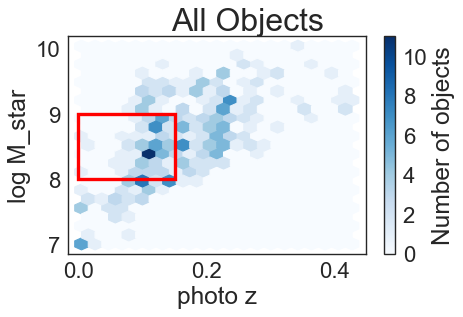

In [148]:
df_tmp = df_features_testing.loc[HSC_ids[testing_set_indices]]
df_tmp["error"] =   np.array(Y[testing_set_indices], dtype=int) \
                  - np.array(predicted_classes, dtype=int)


mask = (df_tmp.photo_z < .5)
# mask &= (df_tmp.error == -1)

print(sum(mask))

plt.hexbin(df_tmp.photo_z[mask], 
           df_tmp.log_mass[mask],
#            C=class_probs,
           gridsize=20,
           cmap="Blues",
           vmin=0,
          )

plt.xlabel("photo z")
plt.ylabel("log M_star")

plt.gca().add_patch(
    patches.Rectangle([0, 8], 
                      .15, 1, 
                      fill=False, 
                      linewidth=3,
                      color="red",
                     ),
)

plt.colorbar(label="Number of objects",
            )

plt.suptitle("All Objects")


348


Text(0.5,0.98,'All Objects')

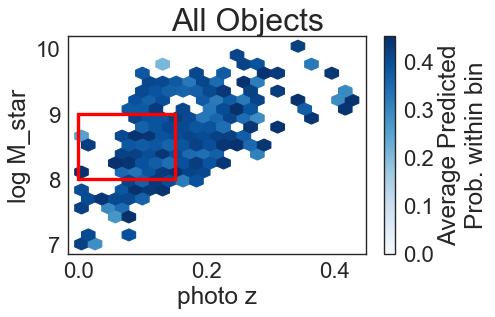

In [146]:
df_tmp = df_features_testing.loc[HSC_ids[testing_set_indices]]
df_tmp["error"] =   np.array(Y[testing_set_indices], dtype=int) \
                  - np.array(predicted_classes, dtype=int)


mask = (df_tmp.photo_z < .5)
# mask &= (df_tmp.error == -1)

print(sum(mask))

plt.hexbin(df_tmp.photo_z[mask], 
           df_tmp.log_mass[mask],
           C=class_probs,
           gridsize=20,
           cmap="Blues",
           vmin=0,
          )

plt.xlabel("photo z")
plt.ylabel("log M_star")

plt.gca().add_patch(
    patches.Rectangle([0, 8], 
                      .15, 1, 
                      fill=False, 
                      linewidth=3,
                      color="red",
                     ),
)

plt.colorbar(label="Average Predicted\nProb. within bin",
            )


plt.suptitle("All Objects")


^^ Huh, that's a pretty uniform looking spread. It doesn't really seem like it's trending in an useful direction (either near the desired boundaries or as you go further away).

243


Text(0.5,0.98,'False Positives')

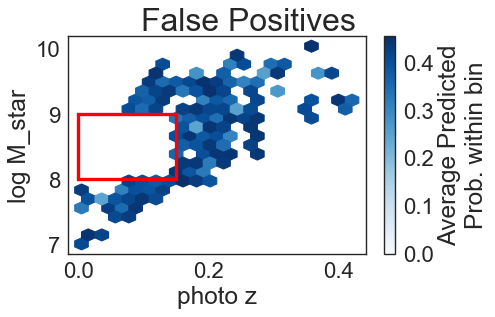

In [147]:
df_tmp = df_features_testing.loc[HSC_ids[testing_set_indices]]
df_tmp["error"] =   np.array(Y[testing_set_indices], dtype=int) \
                  - np.array(predicted_classes, dtype=int)


mask = (df_tmp.photo_z < .5)
mask &= (df_tmp.error == -1)

print(sum(mask))

plt.hexbin(df_tmp.photo_z[mask], 
           df_tmp.log_mass[mask],
           C=class_probs,
           gridsize=20,
           cmap="Blues",
           vmin=0,
          )

plt.xlabel("photo z")
plt.ylabel("log M_star")

plt.gca().add_patch(
    patches.Rectangle([0, 8], 
                      .15, 1, 
                      fill=False, 
                      linewidth=3,
                      color="red",
                     ),
)

plt.colorbar(label="Average Predicted\nProb. within bin",
            )

plt.suptitle("False Positives")
